In [1]:
import pandas as pd
import numpy as np
import pingouin as pg

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit

In [2]:
# 设置中文字体为宋体
plt.rcParams['font.sans-serif'] = ['SimHei']
# 设置英文字体为新罗马
plt.rcParams['font.serif'] = ['Times New Roman']
# 字体大小
plt.rcParams['font.size'] = 12  
# 正常显示负号
plt.rcParams['axes.unicode_minus'] = False 

## 注意啊这里聚合是以日为单位而不是月

In [3]:
import pandas as pd

def get_chengbenjiachengdingjia(file):
    df = pd.read_csv(file, encoding='gbk').drop(["单品编码", "分类编码"], axis=1)

    # 计算平均利润
    df['平均利润'] = (df['销售单价(元/千克)'] - df['批发价格(元/千克)']) * df['销量(千克)']
    # 计算平均利润率
    df['平均利润率'] = (df['销售单价(元/千克)'] - df['批发价格(元/千克)']) / df['批发价格(元/千克)']
    # 计算加成率
    df['加成率'] = df['平均利润率'] / (1 - df['平均利润率'])
    # 计算成本加成定价
    df['成本加成定价'] = df['批发价格(元/千克)'] * (1 + df['加成率'])

    # 如果成本加成定价大于批发价的1.75倍，则将成本加成定价设置为批发价的1.75倍
    max_allowed_price = df['批发价格(元/千克)'] * 1.75
    df['成本加成定价'] = df['成本加成定价'].where(df['成本加成定价'] <= max_allowed_price, max_allowed_price)

    df['成本加成定价'].fillna(0, inplace=True)

    return df


def data_prepare(df):
    df = df.drop(["平均损耗值", "平均利润", "平均利润率", "加成率"], axis=1)
    df['销售日期'] = pd.to_datetime(df['销售日期'])
    df = df.resample('D', on='销售日期').agg({'销量(千克)': 'sum', '成本加成定价': 'mean', '销售单价(元/千克)': 'mean'})   # ------------------------注意啊这里是以日为单位而不是月
    df['日期'] = df.index

    df['成本加成定价'].fillna(0, inplace=True)
    # 将DataFrame中的所有inf值替换为0
    df.replace([np.inf, -np.inf], 0, inplace=True)
    
    return df

In [4]:
df1 = get_chengbenjiachengdingjia("data_2\\花菜类.csv")
df2 = get_chengbenjiachengdingjia("data_2\\花叶类.csv")
df3 = get_chengbenjiachengdingjia("data_2\\茄类.csv")
df4 = get_chengbenjiachengdingjia("data_2\\辣椒类.csv")
df5 = get_chengbenjiachengdingjia("data_2\\食用菌.csv")
df6 = get_chengbenjiachengdingjia("data_2\\水生根茎类.csv")
name = ["花菜类", "花叶类", "茄类", "辣椒类", "食用菌", "水生根茎类"]
df1.head()

,销售日期,扫码销售时间,销量(千克),销售单价(元/千克),批发价格(元/千克),分类名称,平均损耗值,平均利润,平均利润率,加成率,成本加成定价
0,2020-07-01,09:33:09.998,0.329,14.0,9.23,花菜类,15.51,1.56933,0.516793,1.069507,16.1525
1,2020-07-01,09:36:36.108,0.445,9.0,6.03,花菜类,15.51,1.32165,0.492537,0.970588,10.5525
2,2020-07-01,09:46:00.634,0.522,14.0,9.23,花菜类,15.51,2.48994,0.516793,1.069507,16.1525
3,2020-07-01,09:46:43.139,0.368,9.0,6.03,花菜类,15.51,1.09296,0.492537,0.970588,10.5525
4,2020-07-01,09:51:24.696,0.236,14.0,9.23,花菜类,15.51,1.12572,0.516793,1.069507,16.1525


In [5]:
df1_res = data_prepare(df1)
df2_res = data_prepare(df2)
df3_res = data_prepare(df3)
df4_res = data_prepare(df4)
df5_res = data_prepare(df5)
df6_res = data_prepare(df6)
df1_res.head()

,销量(千克),成本加成定价,销售单价(元/千克),日期
销售日期,,,,
2020-07-01,46.640,14.847646,12.834951,2020-07-01
2020-07-02,43.943,13.707105,12.421053,2020-07-02
2020-07-03,42.076,13.270833,12.000000,2020-07-03
2020-07-04,55.662,14.385833,12.619048,2020-07-04
2020-07-05,55.474,14.773632,12.641509,2020-07-05


## 计算成本加成定价

# 孤立森林：用来清除异常值

In [6]:
from sklearn.ensemble import IsolationForest

def deal_out(df1):
    df1['成本加成定价'].fillna(0, inplace=True)

    model = IsolationForest()
    df1['is_outlier'] = model.fit_predict(df1[['成本加成定价']])
    df_cleaned = df1[df1['is_outlier'] != -1]
    return df_cleaned

df1_res_ = deal_out(df1_res)
df2_res_ = deal_out(df2_res)
df3_res_ = deal_out(df3_res)
df4_res_ = deal_out(df4_res)
df5_res_ = deal_out(df5_res)
df6_res_ = deal_out(df6_res)

In [7]:
df1_res_

,销量(千克),成本加成定价,销售单价(元/千克),日期,is_outlier
销售日期,,,,,
2020-07-01,46.640,14.847646,12.834951,2020-07-01,1
2020-07-02,43.943,13.707105,12.421053,2020-07-02,1
2020-07-03,42.076,13.270833,12.000000,2020-07-03,1
2020-07-04,55.662,14.385833,12.619048,2020-07-04,1
2020-07-05,55.474,14.773632,12.641509,2020-07-05,1
...,...,...,...,...,...
2023-06-26,8.083,13.895000,14.000000,2023-06-26,1
2023-06-27,14.272,13.650000,12.000000,2023-06-27,1
2023-06-28,16.069,13.560532,12.277778,2023-06-28,1


C:\Users\jack\AppData\Local\Temp\ipykernel_1384\2669258718.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45)
C:\Users\jack\AppData\Local\Temp\ipykernel_1384\2669258718.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45)


[Text(18506.0, 0, '2020-09'),
 Text(18628.0, 0, '2021-01'),
 Text(18748.0, 0, '2021-05'),
 Text(18871.0, 0, '2021-09'),
 Text(18993.0, 0, '2022-01'),
 Text(19113.0, 0, '2022-05'),
 Text(19236.0, 0, '2022-09'),
 Text(19358.0, 0, '2023-01'),
 Text(19478.0, 0, '2023-05')]

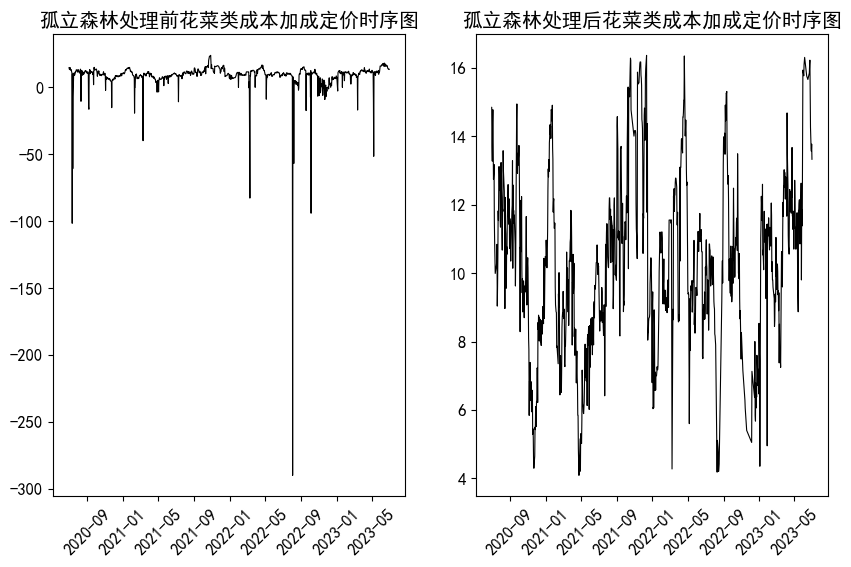

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))
sns.set_style("whitegrid", {'font.sans-serif':['simhei', 'Arial']})

ax[0].plot(df1_res['日期'], df1_res['成本加成定价'], label=name[0], color='black', linewidth=0.8)
ax[1].plot(df1_res_['日期'], df1_res_['成本加成定价'], label=name[1], color='black', linewidth=0.8)

ax[0].set_title("孤立森林处理前花菜类成本加成定价时序图")
ax[1].set_title("孤立森林处理后花菜类成本加成定价时序图")

ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45)
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45)

#plt.savefig('绘图文件夹\\正文图插入1.eps')

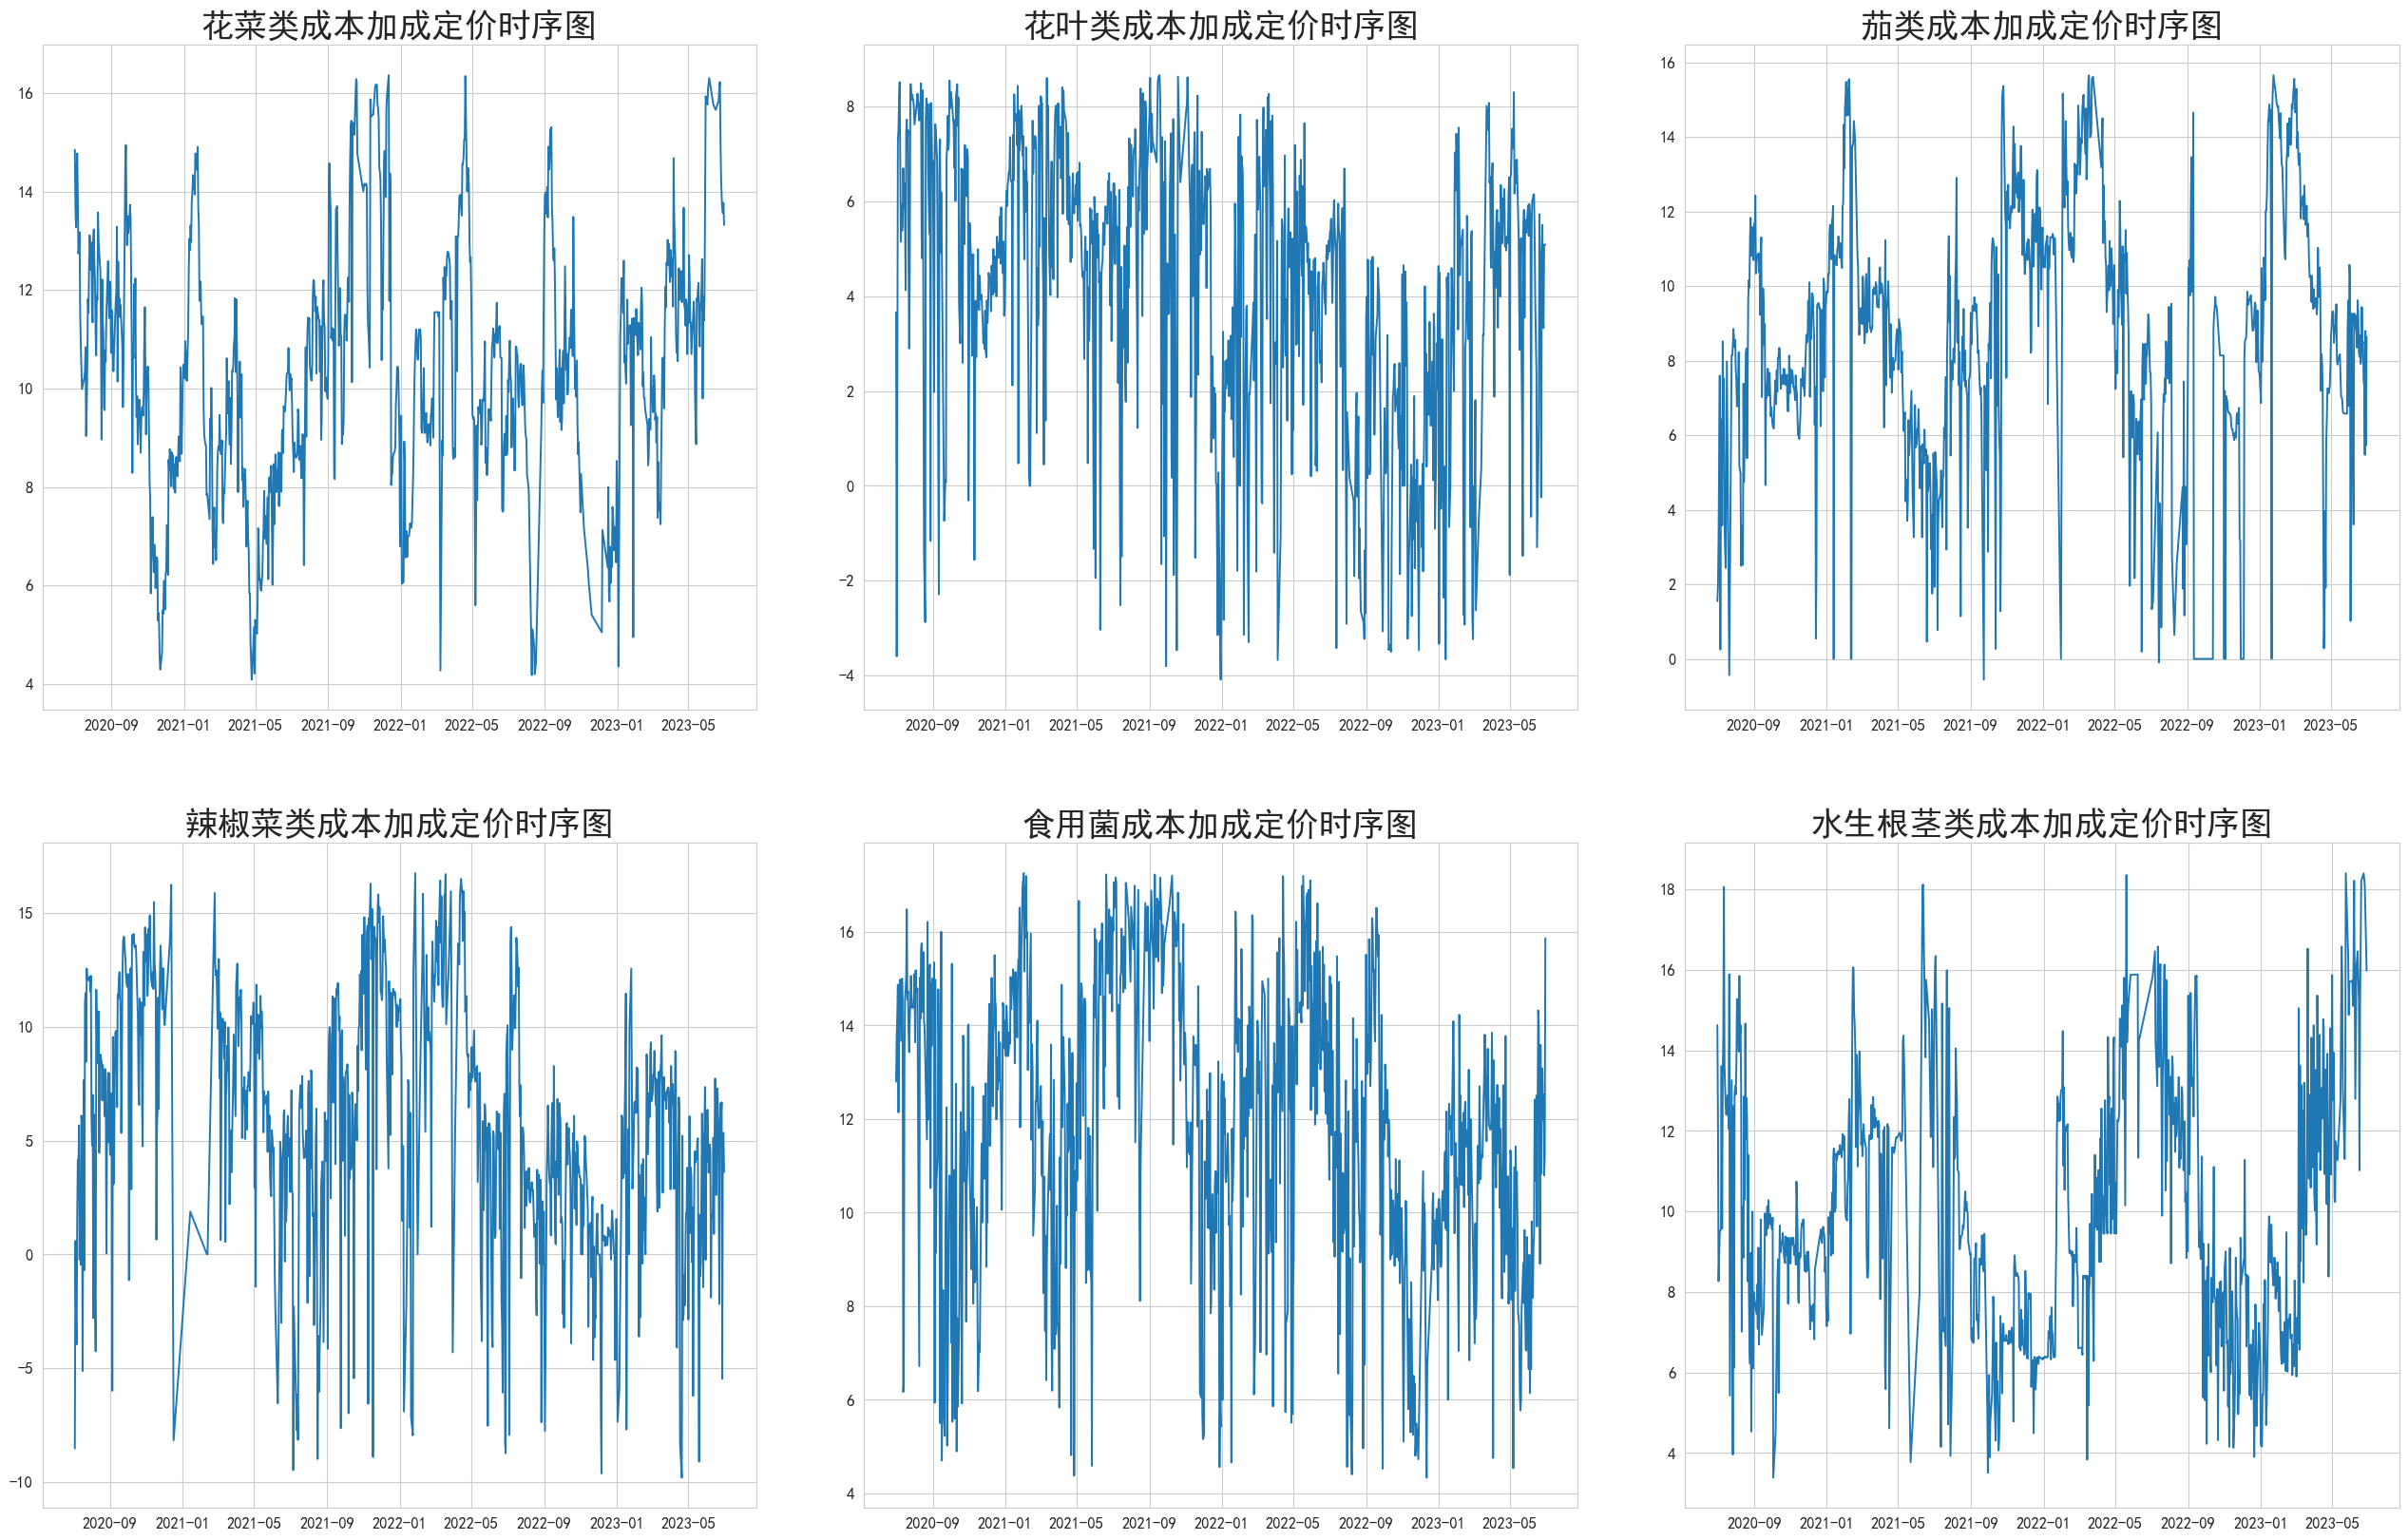

In [9]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(32, 20))
sns.set_style("whitegrid", {'font.sans-serif':['simhei', 'Arial']})

ax[0][0].plot(df1_res_['日期'], df1_res_['成本加成定价'], label=name[0], linewidth=1.4)
ax[0][1].plot(df2_res_['日期'], df2_res_['成本加成定价'], label=name[1], linewidth=1.4)
ax[0][2].plot(df3_res_['日期'], df3_res_['成本加成定价'], label=name[2], linewidth=1.4)
ax[1][0].plot(df4_res_['日期'], df4_res_['成本加成定价'], label=name[3], linewidth=1.4)
ax[1][1].plot(df5_res_['日期'], df5_res_['成本加成定价'], label=name[4], linewidth=1.4)
ax[1][2].plot(df6_res_['日期'], df6_res_['成本加成定价'], label=name[5], linewidth=1.4)

ax[0][0].set_title("花菜类成本加成定价时序图", fontsize=25)
ax[0][1].set_title("花叶类成本加成定价时序图", fontsize=25)
ax[0][2].set_title("茄类成本加成定价时序图", fontsize=25)
ax[1][0].set_title("辣椒菜类成本加成定价时序图", fontsize=25)
ax[1][1].set_title("食用菌成本加成定价时序图", fontsize=25)
ax[1][2].set_title("水生根茎类成本加成定价时序图", fontsize=25)

fig.subplots_adjust(wspace=0.15, hspace=0.2)
plt.savefig('绘图文件夹\\正文图8.eps')

In [10]:
def nor(df):
    print(pg.normality(df["销量(千克)"]))
    print(pg.normality(df["成本加成定价"]))


df1_res = df1_res[df1_res["销量(千克)"] <= 100]
df2_res = df2_res[df2_res["销量(千克)"] <= 400]
df3_res = df3_res[df3_res["销量(千克)"] <= 60]
df4_res = df4_res[df4_res["销量(千克)"] <= 230]
df5_res = df5_res[df5_res["销量(千克)"] <= 200]
df6_res = df6_res[df6_res["销量(千克)"] <= 100]

df1_res = df1_res[df1_res["成本加成定价"] >= 0]
df2_res = df2_res[df2_res["成本加成定价"] >= 0]
df3_res = df3_res[df3_res["成本加成定价"] >= 0]
df4_res = df4_res[df4_res["成本加成定价"] >= 0]
df5_res = df5_res[df5_res["成本加成定价"] >= 0]
df6_res = df6_res[df6_res["成本加成定价"] >= 0]

# 多项式拟合

In [11]:
# 使用polyfit进行多项式拟合
degree1 = 6  # 选择多项式的阶数，这里选择2次多项式
coefficients = np.polyfit(df1_res["销量(千克)"], df1_res["成本加成定价"], degree1)
polynomial_model = np.poly1d(coefficients)
# 生成拟合曲线的x和y值
x_fit1 = np.linspace(df1_res["销量(千克)"].min(), df1_res["销量(千克)"].max(), 100)
y_fit1 = polynomial_model(x_fit1)
# 获取多项式的解析表达式字符串
polynomial_expression = str(polynomial_model)
# 打印解析表达式
print(polynomial_expression)


            6             5            4            3          2
-3.256e-09 x + 1.021e-06 x - 0.000124 x + 0.007295 x - 0.2107 x + 2.586 x + 2.746


In [12]:

# 使用polyfit进行多项式拟合
degree2 = 5 # 选择多项式的阶数，这里选择2次多项式
coefficients = np.polyfit(df2_res["销量(千克)"], df2_res["成本加成定价"], degree2)
polynomial_model = np.poly1d(coefficients)
# 生成拟合曲线的x和y值
x_fit2 = np.linspace(df2_res["销量(千克)"].min(), df2_res["销量(千克)"].max(), 100)
y_fit2 = polynomial_model(x_fit2)
# 获取多项式的解析表达式字符串
polynomial_expression = str(polynomial_model)
# 打印解析表达式
print(polynomial_expression)

           5             4             3            2
3.475e-11 x - 3.608e-08 x + 1.354e-05 x - 0.002281 x + 0.1723 x + 0.4924


In [13]:

# 使用polyfit进行多项式拟合
degree3 = 3 # 选择多项式的阶数，这里选择2次多项式
coefficients = np.polyfit(df3_res["销量(千克)"], df3_res["成本加成定价"], degree3)
polynomial_model = np.poly1d(coefficients)
# 生成拟合曲线的x和y值
x_fit3 = np.linspace(df3_res["销量(千克)"].min(), df3_res["销量(千克)"].max(), 100)
y_fit3 = polynomial_model(x_fit3)
# 获取多项式的解析表达式字符串
polynomial_expression = str(polynomial_model)
# 打印解析表达式
print(polynomial_expression)

           3           2
0.0004488 x - 0.03953 x + 0.93 x + 3.753


In [14]:

# 使用polyfit进行多项式拟合
degree4 = 3 # 选择多项式的阶数，这里选择2次多项式
coefficients = np.polyfit(df4_res["销量(千克)"], df4_res["成本加成定价"], degree4)
polynomial_model = np.poly1d(coefficients)
# 生成拟合曲线的x和y值
x_fit4 = np.linspace(df4_res["销量(千克)"].min(), df4_res["销量(千克)"].max(), 100)
y_fit4 = polynomial_model(x_fit4)
# 获取多项式的解析表达式字符串
polynomial_expression = str(polynomial_model)
# 打印解析表达式
print(polynomial_expression)

           3            2
6.059e-06 x - 0.002048 x + 0.1579 x + 6.853


In [15]:

# 使用polyfit进行多项式拟合
degree5 = 12 # 选择多项式的阶数，这里选择2次多项式
coefficients = np.polyfit(df5_res["销量(千克)"], df5_res["成本加成定价"], degree5)
polynomial_model = np.poly1d(coefficients)
# 生成拟合曲线的x和y值
x_fit5 = np.linspace(df5_res["销量(千克)"].min(), df5_res["销量(千克)"].max(), 100)
y_fit5 = polynomial_model(x_fit5)
# 获取多项式的解析表达式字符串
polynomial_expression = str(polynomial_model)
# 打印解析表达式
print(polynomial_expression)

            12             11             10             9
-7.735e-22 x  + 1.022e-18 x  - 5.932e-16 x  + 1.991e-13 x
              8             7             6             5            4
 - 4.279e-11 x + 6.157e-09 x - 6.025e-07 x + 3.994e-05 x - 0.001752 x
            3          2
 + 0.04856 x - 0.7804 x + 6.081 x - 0.1866


In [16]:

# 使用polyfit进行多项式拟合
degree6 = 4 # 选择多项式的阶数，这里选择2次多项式
coefficients = np.polyfit(df6_res["销量(千克)"], df6_res["成本加成定价"], degree6)
polynomial_model = np.poly1d(coefficients)
# 生成拟合曲线的x和y值
x_fit6 = np.linspace(df6_res["销量(千克)"].min(), df6_res["销量(千克)"].max(), 100)
y_fit6 = polynomial_model(x_fit6)

# 获取多项式的解析表达式字符串
polynomial_expression = str(polynomial_model)
# 打印解析表达式
print(polynomial_expression)

           4             3           2
-2.28e-06 x + 0.0004272 x - 0.02385 x + 0.3294 x + 11.88


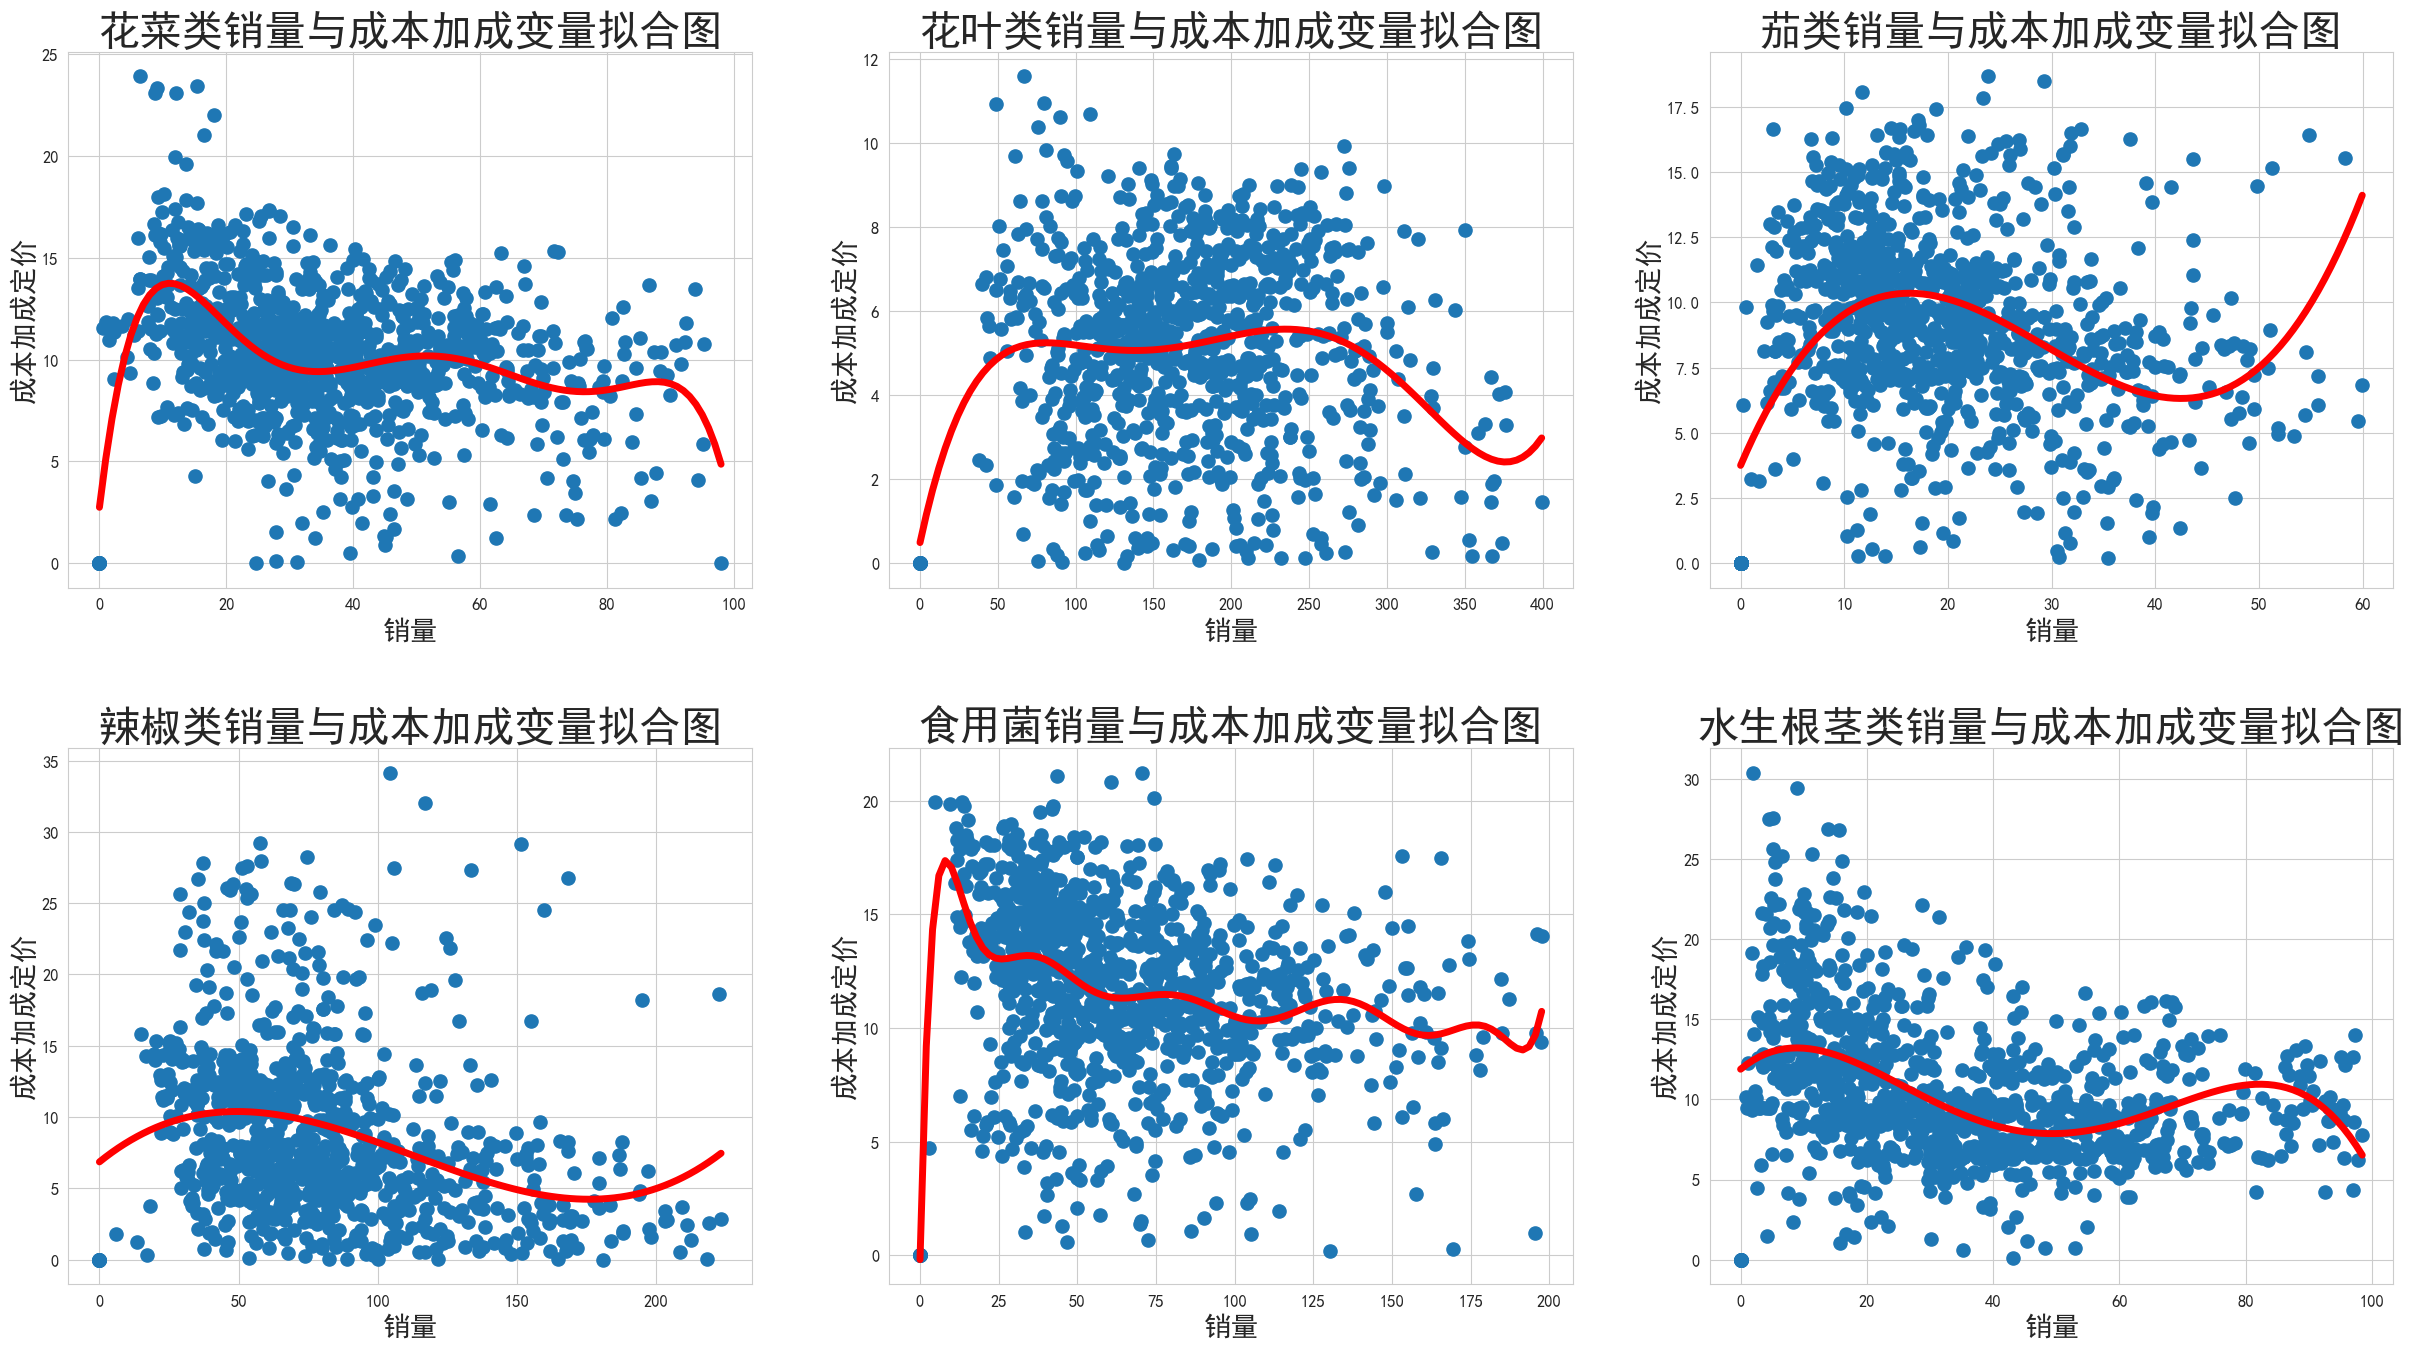

In [17]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(30, 16))
fig.subplots_adjust(wspace=0.2, hspace=0.3) 
sns.set_style("white", {'font.sans-serif':['simhei', 'Arial']})

# 绘制原始数据和拟合曲线
ax[0][0].scatter(df1_res["销量(千克)"], df1_res["成本加成定价"], label='Data', s=90)
ax[0][0].plot(x_fit1, y_fit1, label=f'Polynomial Fit (Degree {degree1})', color='red', linewidth=5)
ax[0][0].set_xlabel('销量', fontsize=20)
ax[0][0].set_ylabel('成本加成定价', fontsize=20)
ax[0][0].set_title('花菜类销量与成本加成变量拟合图', fontsize=30)

# 绘制原始数据和拟合曲线
ax[0][1].scatter(df2_res["销量(千克)"], df2_res["成本加成定价"], label='Data', s=90)
ax[0][1].plot(x_fit2, y_fit2, label=f'Polynomial Fit (Degree {degree2})', color='red', linewidth=5)
ax[0][1].set_xlabel('销量', fontsize=20)
ax[0][1].set_ylabel('成本加成定价', fontsize=20)
ax[0][1].set_title('花叶类销量与成本加成变量拟合图', fontsize=30)

# 绘制原始数据和拟合曲线
ax[0][2].scatter(df3_res["销量(千克)"], df3_res["成本加成定价"], label='Data', s=90)
ax[0][2].plot(x_fit3, y_fit3, label=f'Polynomial Fit (Degree {degree3})', color='red', linewidth=5)
ax[0][2].set_xlabel('销量', fontsize=20)
ax[0][2].set_ylabel('成本加成定价', fontsize=20)
ax[0][2].set_title('茄类销量与成本加成变量拟合图', fontsize=30)


# 绘制原始数据和拟合曲线
ax[1][0].scatter(df4_res["销量(千克)"], df4_res["成本加成定价"], label='Data', s=90)
ax[1][0].plot(x_fit4, y_fit4, label=f'Polynomial Fit (Degree {degree4})', color='red', linewidth=5)
ax[1][0].set_xlabel('销量', fontsize=20)
ax[1][0].set_ylabel('成本加成定价', fontsize=20)
ax[1][0].set_title('辣椒类销量与成本加成变量拟合图', fontsize=30)


# 绘制原始数据和拟合曲线
ax[1][1].scatter(df5_res["销量(千克)"], df5_res["成本加成定价"], label='Data', s=90)
ax[1][1].plot(x_fit5, y_fit5, label=f'Polynomial Fit (Degree {degree5})', color='red', linewidth=5)
ax[1][1].set_xlabel('销量', fontsize=20)
ax[1][1].set_ylabel('成本加成定价', fontsize=20)
ax[1][1].set_title('食用菌销量与成本加成变量拟合图', fontsize=30)


# 绘制原始数据和拟合曲线
ax[1][2].scatter(df6_res["销量(千克)"], df6_res["成本加成定价"], label='Data', s=90)
ax[1][2].plot(x_fit6, y_fit6, label=f'Polynomial Fit (Degree {degree6})', color='red', linewidth=5)
ax[1][2].set_xlabel('销量', fontsize=20)
ax[1][2].set_ylabel('成本加成定价', fontsize=20)
ax[1][2].set_title('水生根茎类销量与成本加成变量拟合图', fontsize=30)

plt.savefig('绘图文件夹\\正文图9.eps')